# Imports

In [64]:
import numpy as np
import numba
from Fit import Fit
from funcs import *
from stats import *
import scienceplots
plt.style.use(['science','no-latex','grid'])

# Funcs

In [65]:
def G_R(w, R, R_L, L, C):
    return R / np.sqrt( (R+R_L)**2 + np.power(w*L - 1/(w*C), 2) )

def fase_R(w, R, R_L, L, C):
    return -np.arctan( (w*L - 1/(w*C)) / (R+R_L) )

def G(w, R, R_L, L, C):
    num = np.sqrt( np.power( R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2) , 2) + R*R*np.power(w*L - 1/(w*C), 2))
    return num / (np.power(R+R_L, 2) + np.power(w*L - 1 /(w*C), 2))

def fase(w, R, R_L, L, C):
    return -np.arctan(R*(w*L - 1/(w*C)) / (R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2)))

# RLC

In [66]:
if 1:
    path_folder = 'data.leo/RLC_R_4021/'
    V_res, V_l, fase_res, fase_l, freqs, V_res_err, V_l_err = [], [], [], [], [], [], []

    for i in sorted([int(i) for i in os.listdir(path_folder)]):

        path = path_folder+str(i)+'/'

        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err, zero_err = analize(path, i, force=True, prec=1e-8,verbose=True)
        
        x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)

        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # # plt.plot(CH1[0], CH1[1], label='CH1', color='red')
        # # plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
        # # plt.plot(MTH[0], MTH[1], label='MTH', color='green')

        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='green', label='zero MTH')
        # plt.legend(ncol=2)
        # plt.show()
        # print(i, dt_CH1, dt_MTH)

        V_res.append(V_SGN)
        V_l.append(V_MTH)
        V_res_err.append(V_SGN_err)
        V_l_err.append(V_MTH_err)
        fase_res.append(dt_CH1*i*2*np.pi)
        fase_l.append(dt_MTH*i*2*np.pi)
        freqs.append(i)

    V_res = np.array(V_res)
    V_l = np.array(V_l)
    V_res_err = np.array(V_res_err)
    V_l_err = np.array(V_l_err)
    fase_res = -np.array(fase_res) + np.pi
    fase_l = (np.array(fase_l) - np.pi)
    freqs = np.array(freqs)

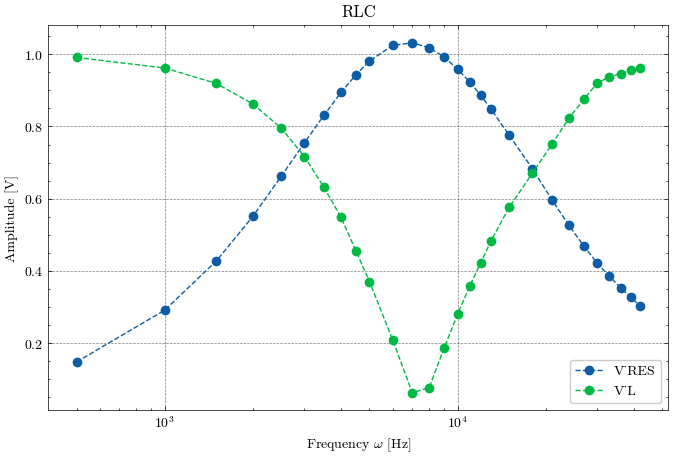

In [67]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')

plt.plot(freqs, V_res, 'o--', label='V_RES')
plt.plot(freqs, V_l, 'o--', label='V_L')
plt.title('RLC')
plt.xlabel('Frequency $\omega$ [Hz]')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


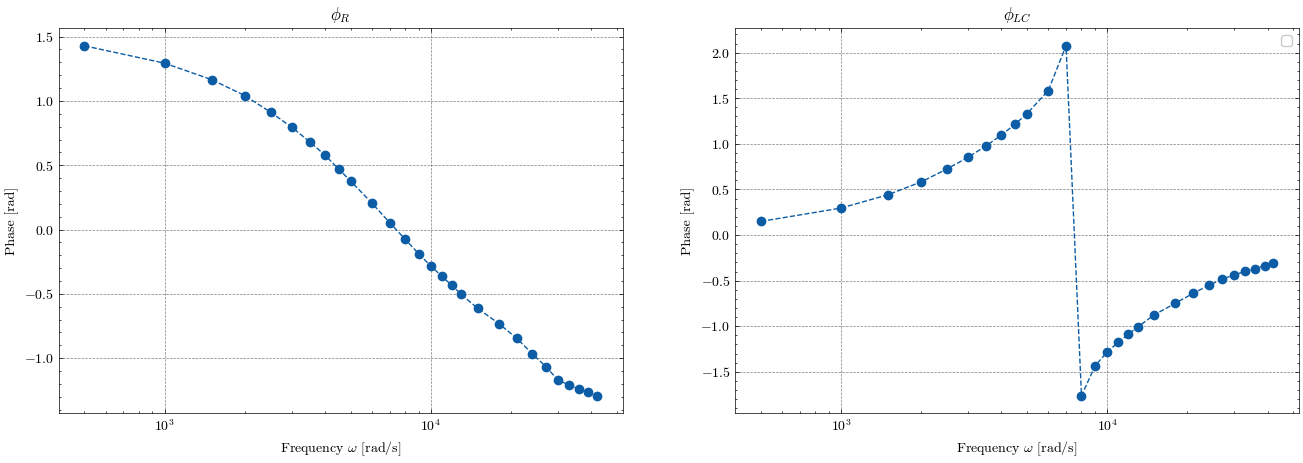

In [68]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

fase_res_mod = np.array(fase_res)
d = fase_res_mod < 0
u = fase_res_mod > 0
fase_res_mod[d] += 2*np.pi
fase_res_mod -= np.pi

d = fase_l < 0
u = fase_l > 0
fase_l_mod = np.array(fase_l)
fase_l_mod[d] = fase_l_mod[d] + np.pi
fase_l_mod[u] = fase_l_mod[u] - np.pi

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,2)
plt.plot(freqs[:], fase_l_mod[:],'o--', lw=1)
plt.title('$\phi_{LC}$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,1)
plt.plot(freqs[:], fase_res_mod[:], 'o--', lw=1)
# plt.plot(x, fase_C(x*2*np.pi, 1e3, 12e-9, 0), label='Teorico')
# plt.plot(x, fase_R(x*2*np.pi, 1e3, 12e-9), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()

In [69]:
with open('RLC_R_4021.tmp.data', 'w') as f:
    for a,b,c,d,e in zip(V_res, V_l, fase_res_mod, fase_l_mod, freqs):
        f.write(f'{a} {b} {c} {d} {e}\n')

# R

In [70]:
c = LeastSquares(freqs*2*np.pi, V_res, V_res_err*300, G_R, verbose=False)
f_m = Minuit(c, R=4021, R_L=39.9, L=40e-3, C=12e-9)
f_m.fixed['R_L'] = True
f_m.migrad()
f_m.hesse()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1251 (χ²/ndof = 50.0)      │              Nfcn = 564              │
│ EDM = 2.06 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  36.3e3   │   1.4e3   │            │            │         │         │       │
│ 1 │ R_L  │   39.9    │    0.4    │            │            │         │         │  yes  │
│ 2 │ L    │   0.418   │   0.016   │            │            │         │         │       │
│ 3 │ C    │  1.32e-9  │  0.05e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────┐
│     │                    R                  R_L                    L                    C │
├─────┼─────────────────────────────────────────────────────────────────────────────────────┤
│   R │             1.87e+06                    0             21.53011 -68.1132096873211e-9 │
│ R_L │                    0                    0                    0                    0 │
│   L │             21.53011                    0             0.000248     -784.1081048e-15 │
│   C │ -68.1132096873211e-9                    0     -784.1081048e-15             2.49e-21 │
└─────┴─────────────────────────────────────────────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


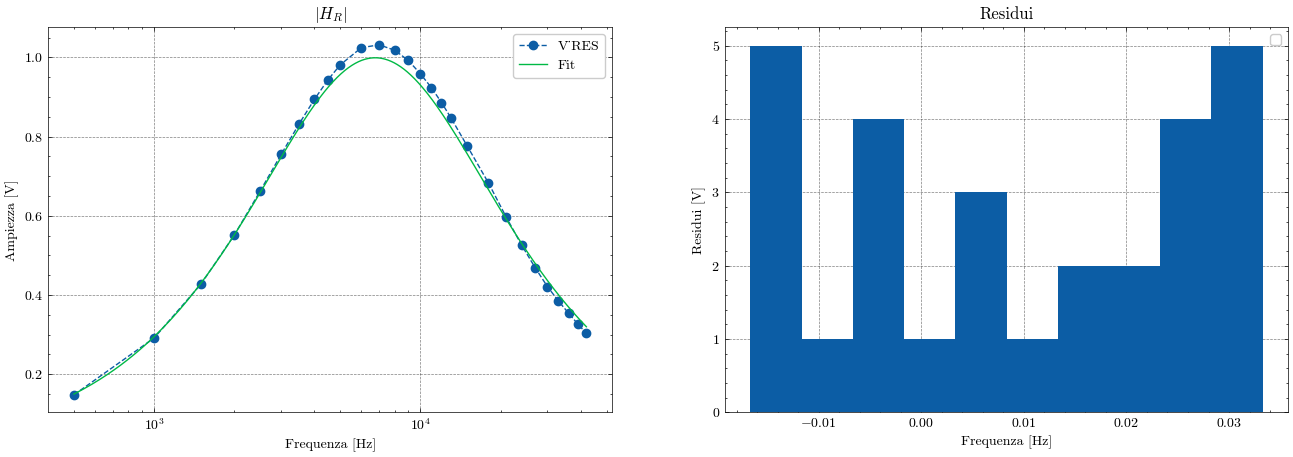

In [71]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(freqs, V_res, 'o--', label='V_RES')
plt.plot(x, G_R(x*2*np.pi, **f_m.values.to_dict()), label='Fit')
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Ampiezza [V]')
plt.title('$|H_R|$')  
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = V_res - G_R(freqs*2*np.pi, **f_m.values.to_dict())
# plt.plot(freqs, res, 'o--', label='Residui')
plt.hist(res, bins=10)
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Residui [V]')
plt.title('Residui')
# plt.xscale('log')
plt.legend()

In [72]:
c = LeastSquares(freqs*2*np.pi, fase_res_mod, 0.01*np.ones_like(fase_res_mod), fase_R, verbose=False)
f_f = Minuit(c, R=4021, R_L=39.9, L=40e-3, C=12e-9)
f_f.fixed['R','R_L'] = True
f_f.migrad()
f_f.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 399.8 (χ²/ndof = 15.4)     │              Nfcn = 53               │
│ EDM = 3.51e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  4.02e3   │  0.04e3   │            │            │         │         │  yes  │
│ 1 │ R_L  │   39.9    │    0.4    │            │            │         │         │  yes  │
│ 2 │ L    │ 43.85e-3  │  0.23e-3  │            │            │         │         │       │
│ 3 │ C    │ 10.54e-9  │  0.06e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────┐
│     │             R           R_L             L             C │
├─────┼─────────────────────────────────────────────────────────┤
│   R │             0             0             0         0e-21 │
│ R_L │             0             0             0         0e-21 │
│   L │             0             0      5.28e-08 -8.070878e-15 │
│   C │         0e-21         0e-21 -8.070878e-15      3.98e-21 │
└─────┴─────────────────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


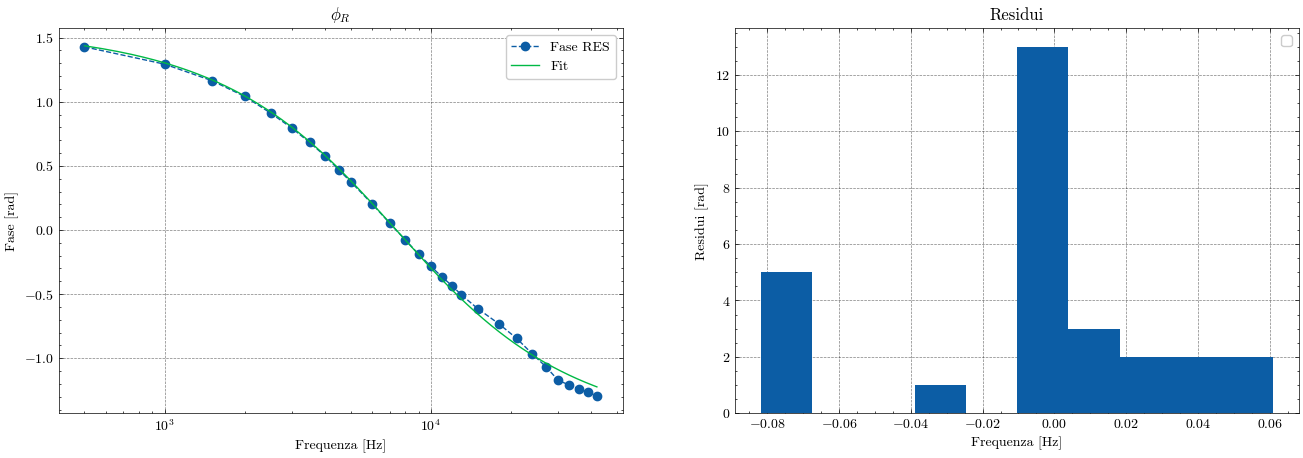

In [73]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)
plt.subplots(1,2,figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(freqs, fase_res_mod, 'o--', label='Fase RES')
plt.plot(x, fase_R(x*2*np.pi, **f_f.values.to_dict()), label='Fit')
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Fase [rad]')
plt.title('$\phi_R$')
plt.xscale('log')
plt.legend()

plt.subplot(1,2,2)
res = fase_res_mod - fase_R(freqs*2*np.pi, **f_f.values.to_dict())
# plt.plot(freqs, res, 'o--', label='Residui')
plt.hist(res, bins=10)
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Residui [rad]')
plt.title('Residui')
# plt.xscale('log')
plt.legend()

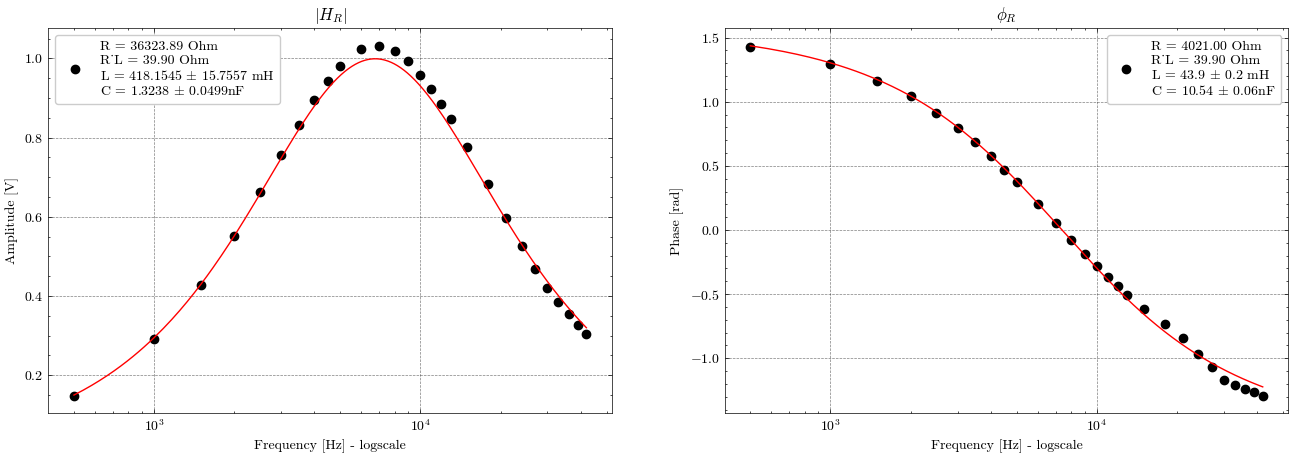

In [74]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(freqs, V_res, 'o', label='dati', c='k')
plt.plot(x, G_R(x*2*np.pi, **f_m.values.to_dict()), label='Fit $|H_R|$', c='r')
plt.title('$|H_R|$')
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')
plt.xscale('log')
plt.legend([f'R = {f_m.values["R"]:.2f} Ohm\n'f'R_L = {f_m.values["R_L"]:.2f} Ohm\n'f'L = {f_m.values["L"]*1e3:.4f} $\pm$ {f_m.errors["L"]*1e3:.4f} mH\n'f'C = {f_m.values["C"]*1e9:.4f} $\pm$ {f_m.errors["C"]*1e9:.4f}nF'])

plt.subplot(1,2,2)
plt.plot(freqs, fase_res_mod, 'o', label='dati', c='k')
plt.plot(x, fase_R(x*2*np.pi, **f_f.values.to_dict()), label='Fit $\phi_R$', c='r')
plt.title('$\phi_R$')
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Phase [rad]')
plt.xscale('log')
plt.legend([f'R = {f_f.values["R"]:.2f} Ohm\n'f'R_L = {f_f.values["R_L"]:.2f} Ohm\n'f'L = {f_f.values["L"]*1e3:.1f} $\pm$ {f_f.errors["L"]*1e3:.1f} mH\n'f'C = {f_f.values["C"]*1e9:.2f} $\pm$ {f_f.errors["C"]*1e9:.2f}nF'])

plt.savefig('imgs/RLC/R.pdf', bbox_inches='tight')

# LC

In [75]:
c = LeastSquares(freqs*2*np.pi, V_l, V_l_err, G, verbose=False)
f_m = Minuit(c, R=997, R_L=39.9, L=40e-3, C=11.5e-9)
f_m.fixed['R','R_L', 'L', 'C'] = True, True, False, False
f_m.simplex()
f_m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.064e+07 (χ²/ndof = 3486163.2)│              Nfcn = 149              │
│ EDM = 1.15e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │    997    │    10     │            │            │         │         │  yes  │
│ 1 │ R_L  │   39.9    │    0.4    │            │            │         │         │  yes  │
│ 2 │ L    │10.74649e-3│0.00007e-3 │            │            │         │         │       │
│ 3 │ C    │42.26783e-9│0.00029e-9 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────┐
│     │             R           R_L             L             C │
├─────┼─────────────────────────────────────────────────────────┤
│   R │             0             0         0e-15             0 │
│ R_L │             0             0         0e-15             0 │
│   L │         0e-15         0e-15      4.77e-15 -14.15535e-21 │
│   C │             0             0 -14.15535e-21      8.63e-26 │
└─────┴─────────────────────────────────────────────────────────┘

In [76]:
c = LeastSquares(freqs*2*np.pi, fase_l_mod, 0.01*np.ones_like(fase_l), fase, verbose=False)
f_f = Minuit(c, R=4021, R_L=39.9, L=40e-3, C=12e-9)
f_f.fixed['R', 'R_L'] = True
f_f.migrad()
f_f.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8802 (χ²/ndof = 338.5)     │              Nfcn = 66               │
│ EDM = 2.7e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  4.02e3   │  0.04e3   │            │            │         │         │  yes  │
│ 1 │ R_L  │   39.9    │    0.4    │            │            │         │         │  yes  │
│ 2 │ L    │ 41.73e-3  │  0.21e-3  │            │            │         │         │       │
│ 3 │ C    │ 10.98e-9  │  0.05e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────┐
│     │               R             R_L               L               C │
├─────┼─────────────────────────────────────────────────────────────────┤
│   R │               0               0               0               0 │
│ R_L │               0               0               0               0 │
│   L │               0               0        4.31e-08 -10.2090018e-15 │
│   C │               0               0 -10.2090018e-15        2.87e-21 │
└─────┴─────────────────────────────────────────────────────────────────┘

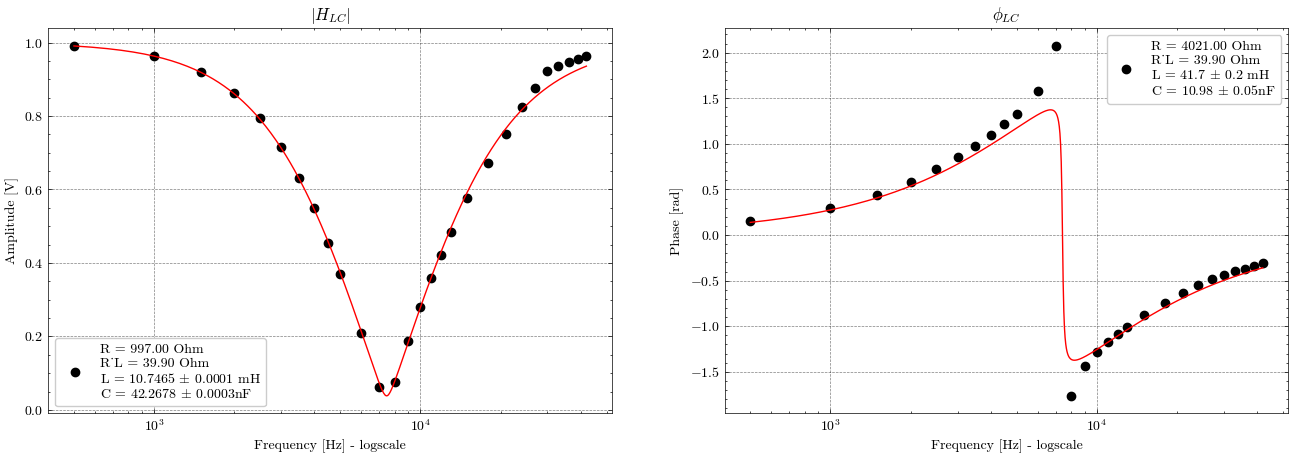

In [77]:
plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(freqs, V_l, 'o', label='dati', c='k')
plt.plot(x, G(x*2*np.pi, **f_m.values.to_dict()), label='Fit $|H_L|$', c='r')
plt.title('$|H_{LC}|$')
plt.legend([f'R = {f_m.values["R"]:.2f} Ohm\n'f'R_L = {f_m.values["R_L"]:.2f} Ohm\n'f'L = {f_m.values["L"]*1e3:.4f} $\pm$ {f_m.errors["L"]*1e3:.4f} mH\n'f'C = {f_m.values["C"]*1e9:.4f} $\pm$ {f_m.errors["C"]*1e9:.4f}nF'])
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Amplitude [V]')
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs, fase_l_mod, 'o', label='dati', c='k')
plt.plot(x, fase(x*2*np.pi, **f_f.values.to_dict()), label='Fit $\phi_L$', c='r')
plt.title('$\phi_{LC}$')
plt.legend([f'R = {f_f.values["R"]:.2f} Ohm\n'f'R_L = {f_f.values["R_L"]:.2f} Ohm\n'f'L = {f_f.values["L"]*1e3:.1f} $\pm$ {f_f.errors["L"]*1e3:.1f} mH\n'f'C = {f_f.values["C"]*1e9:.2f} $\pm$ {f_f.errors["C"]*1e9:.2f}nF'])
plt.xlabel('Frequency [Hz] - logscale')
plt.ylabel('Phase [rad]')
plt.xscale('log')
plt.savefig('imgs/RLC/LC.pdf', bbox_inches='tight')